In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
from scipy import interpolate
from scipy.special import factorial
import h5py
import copy

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions') # changes per computer
#import magaoxFunctions as mf
import psd_functions as psd
import zernike as zern
import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 28/04/2020 16:42:54


In [32]:
# open up all the files here

opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'surf_units': u.micron,
             'ring_width': 5} # useful for PSD

fm_num=8 # pick one mirror
tot_step=6
fits_folder = 'flat_mirrors/fixed_fits/'

for ns in range(0, tot_step):
    fits_file = fits_folder+'flat_2in_ca{0}_n{1}_step{2}'.format(opt_parms['ca'], fm_num, ns)
    
    if ns==0: # initialize first time
        mask_fits = fits.open(fits_file+'_mask.fits')[0]
        mask = mask_fits.data
        opt_parms['wavelen'] = mask_fits.header['wavelen']*u.m
        opt_parms['latres'] = mask_fits.header['latres']*u.m/u.pix
        data_set = np.zeros((tot_step, np.shape(mask)[0], np.shape(mask)[0])) # initialize variable
    
    # write data to a matrix
    data_set[ns, :, :] = fits.open(fits_file+'_surf.fits')[0].data

# apply matrix units
data_set *= opt_parms['surf_units']

# flatten the data (useful for other calculations)
flat_data = np.zeros((tot_step, np.product(np.shape(mask))))
for n in range(0, tot_step):
    flat_data[n] = np.reshape(data_set[n],np.product(np.shape(mask)))

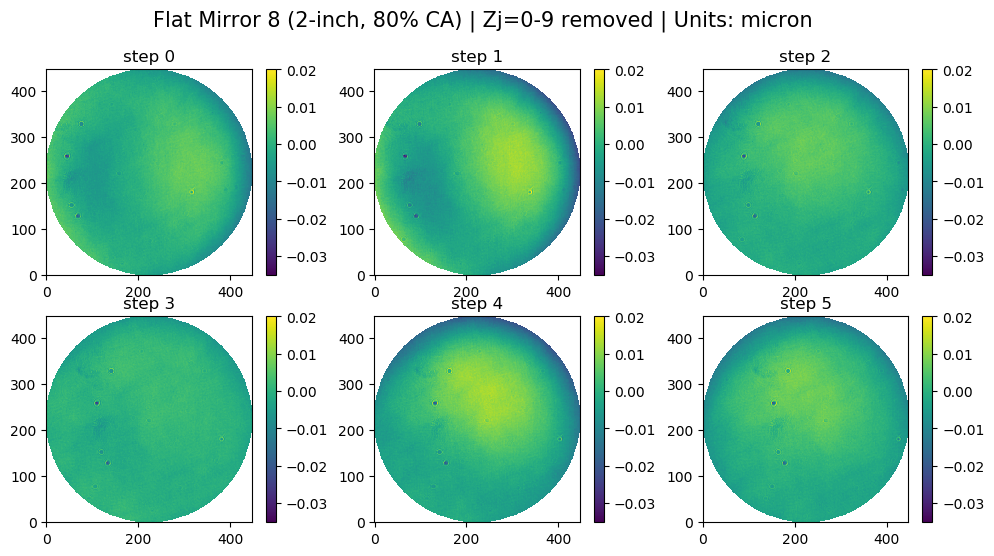

In [33]:
# calc min and max
vmin = np.amin(data_set.value)
vmax = np.amax(data_set.value)

plt.figure(figsize=[12, 6], dpi=100)
plt.suptitle('Flat Mirror 8 (2-inch, {0}% CA) | Zj=0-9 removed | Units: {1}'.format(opt_parms['ca'], data_set[0].unit), fontsize=15)
for n in range(0,tot_step):  
    order = '23{0}'.format(n+1)
    plt.subplot(order)
    plt.imshow(dfx.sn_map(data_set[n].value,mask), origin='lower', vmin=vmin, vmax=vmax)
    plt.title('step {0}'.format(n))
    plt.colorbar()

## Median calculation

In [43]:
# generate the median data
#med_data = np.median(flat_data, axis=0).reshape(np.shape(mask))
medfm_bias = np.zeros((np.product(np.shape(mask))))
for k in range(0, np.product(np.shape(mask))):
    pix_data = flat_data[:,k]
    pix_bin = pix_data[~np.isnan(pix_data)]
    medfm_bias[k] = np.median(pix_bin)

# reshape    
medfm_bias = medfm_bias.reshape(np.shape(mask))*data_set.unit

# write the files - needs to be fixed
#file_bias = fits_folder+'flat_2in_ca{0}_n{1}_median_bias'.format(opt_parms['ca'], fm_num)
#dfx.write_fits(surface=medfm_bias, mask=mask, surf_parms=opt_parms, filename=file_bias)

Text(0.5, 1.0, 'Median data (micron)')

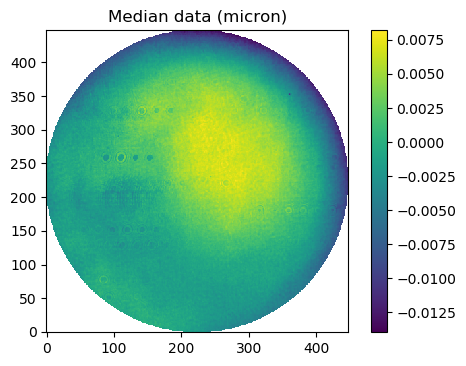

In [35]:
# show the plot of the median data
plt.figure(dpi=100)
plt.imshow(dfx.sn_map(medfm_bias,mask), origin='lower')
plt.colorbar()
plt.title('Median data ({0})'.format(data_set.unit))

## Single dust masking

In [36]:
test_data = copy.copy(data_set)
dust_center = [ (46, 259), (68, 259), (89, 259), (111, 259), (133, 259), (154, 259)]
dust_radius=8

mask_sum = np.ones_like(mask).astype(float)

for n in range(0, len(dust_center)):
    mask_step = np.ones_like(mask).astype(float)
    dmc = np.zeros_like(mask)
    dm_coord = draw.circle(r=dust_center[n][1], c=dust_center[n][0], radius=dust_radius)
    dmc[dm_coord] = True
    mask_step[dmc==True] = np.nan
    test_data[n] = data_set[n]*mask_step
    mask_sum*=mask_step
    
# flatten the data 
mask1_data = np.zeros((tot_step, np.product(np.shape(mask))))
for n in range(0, tot_step):
    mask1_data[n] = np.reshape(test_data[n],np.product(np.shape(mask)))

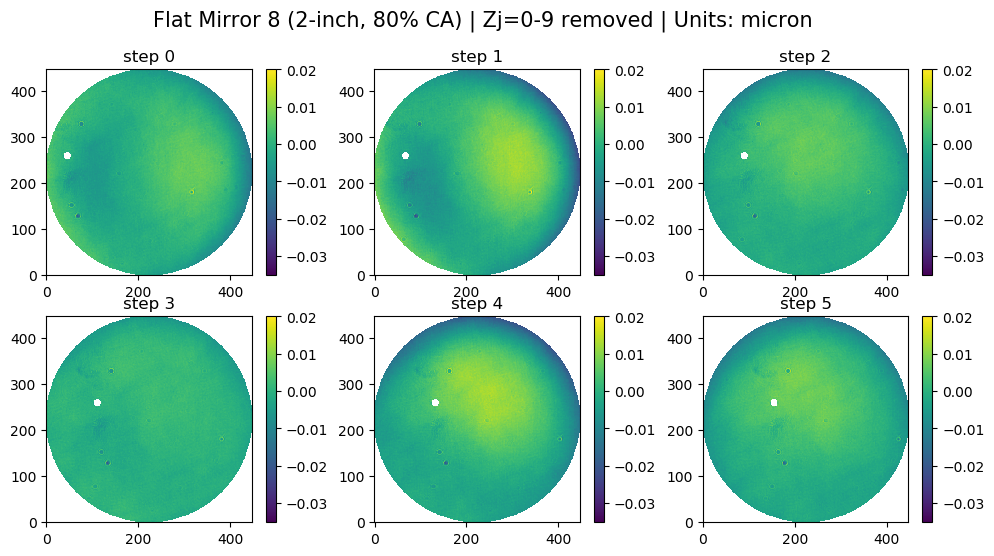

In [39]:
# plot dust mask maps
vmin = np.amin(data_set.value)
vmax = np.amax(data_set.value)

plt.figure(figsize=[12, 6], dpi=100)
plt.suptitle('Flat Mirror 8 (2-inch, {0}% CA) | Zj=0-9 removed | Units: {1}'.format(opt_parms['ca'], data_set[0].unit), fontsize=15)
for n in range(0,tot_step):  
    order = '23{0}'.format(n+1)
    plt.subplot(order)
    plt.imshow(dfx.sn_map(test_data[n].value,mask), origin='lower', vmin=vmin, vmax=vmax)
    plt.title('step {0}'.format(n))
    plt.colorbar()

In [44]:
# calculate the median
medfm_mask1 = np.zeros((np.product(np.shape(mask))))
for k in range(0, np.product(np.shape(mask))):
    # unbiased data
    pix_data = mask1_data[:,k]
    pix_bin = pix_data[~np.isnan(pix_data)]
    medfm_mask1[k] = np.median(pix_bin)

# reshape    
medfm_mask1 = medfm_mask1.reshape(np.shape(mask))*data_set.unit

# write the files - need to fix
#file_mask1 = fits_folder+'flat_2in_ca{0}_n{1}_median_1dustbias'.format(opt_parms['ca'], fm_num)
#dfx.write_fits(surface=medfm_mask1, mask=mask, surf_parms=sp, filename=file_mask1)

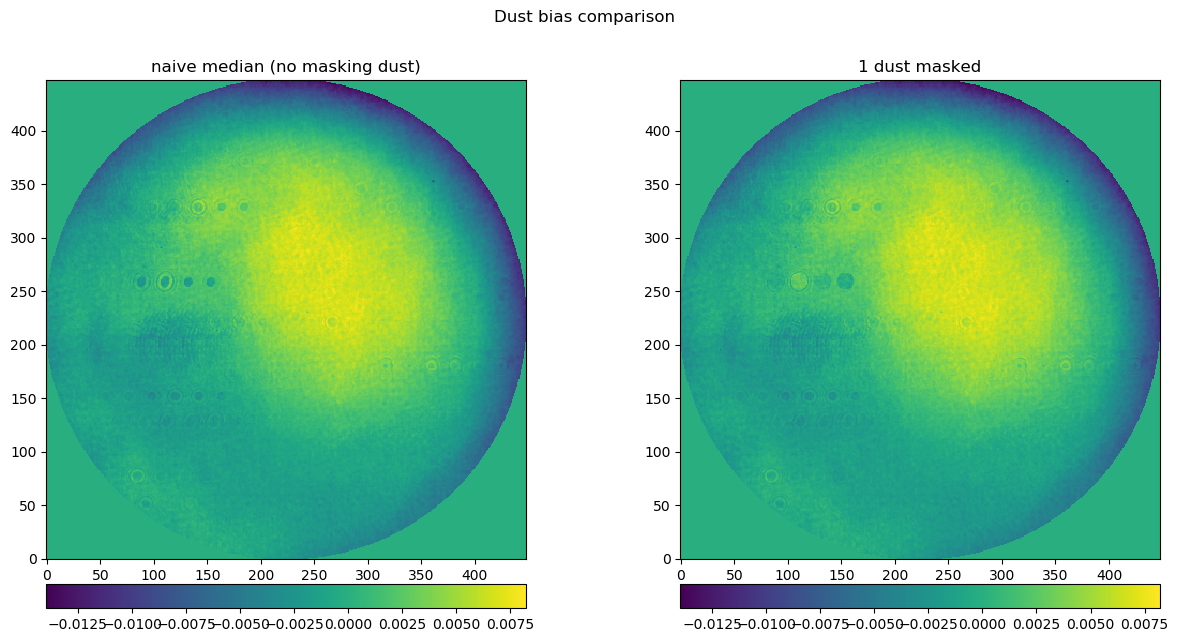

In [41]:
dfx.show2plots(supertitle='Dust bias comparison',
               data1 = medfm_bias,
               plot1_label='naive median (no masking dust)',
               data2 = medfm_mask1,
               plot2_label='1 dust masked',
               set_figsize=[15,7],
               set_dpi=100)

In [45]:
# generate the PSDs

# biased data
n_step = 'bias_median'
fm_bias = psd.surfPSD(surf_name = n_step)
fm_bias.load_surf(data=medfm_bias, wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
fm_bias.load_mask(mask=mask)
fm_bias.calc_psd(oversamp = opt_parms['ovs'])
fm_bias.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for {0} complete'.format(n_step))

# unbiased data
n_step = 'mask1dust'
fm_mask1 = psd.surfPSD(surf_name = n_step)
fm_mask1.load_surf(data=medfm_mask1, wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
fm_mask1.load_mask(mask=mask)
fm_mask1.calc_psd(oversamp = opt_parms['ovs'])
fm_mask1.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for {0} complete'.format(n_step))

PSD and radial profile for bias_median complete

PSD and radial profile for mask1dust complete



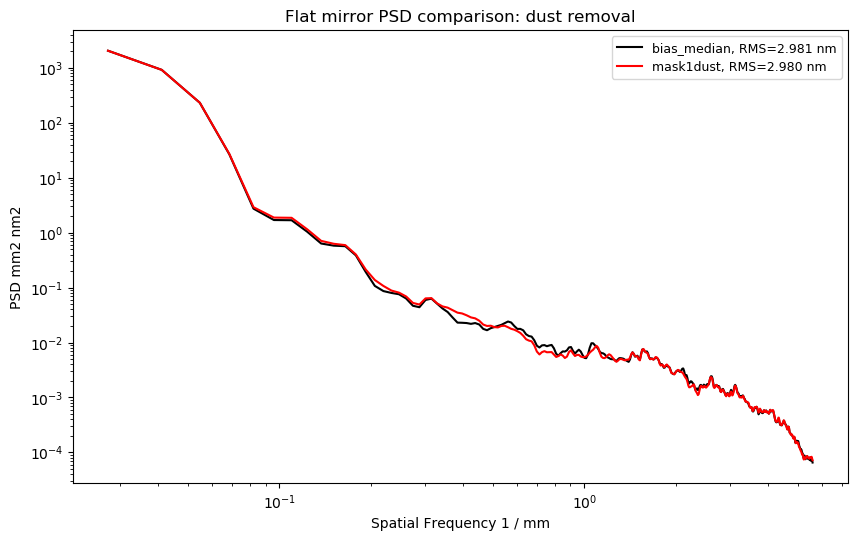

In [46]:
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(fm_bias.k_radial.value, fm_bias.psd_radial_cal.value, 'k', label='{0}, RMS={1:.3f}'.format(fm_bias.surf_name, fm_bias.rms))
plt.loglog(fm_mask1.k_radial.value, fm_mask1.psd_radial_cal.value, 'r', label='{0}, RMS={1:.3f}'.format(fm_mask1.surf_name, fm_mask1.rms))
plt.xlabel('Spatial Frequency {0}'.format(fm_bias.k_radial.unit))
plt.ylabel('PSD {0}'.format(fm_bias.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust removal')
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})

## Pixel Filtering

Text(0.5, 1.0, 'Dust pixel testing')

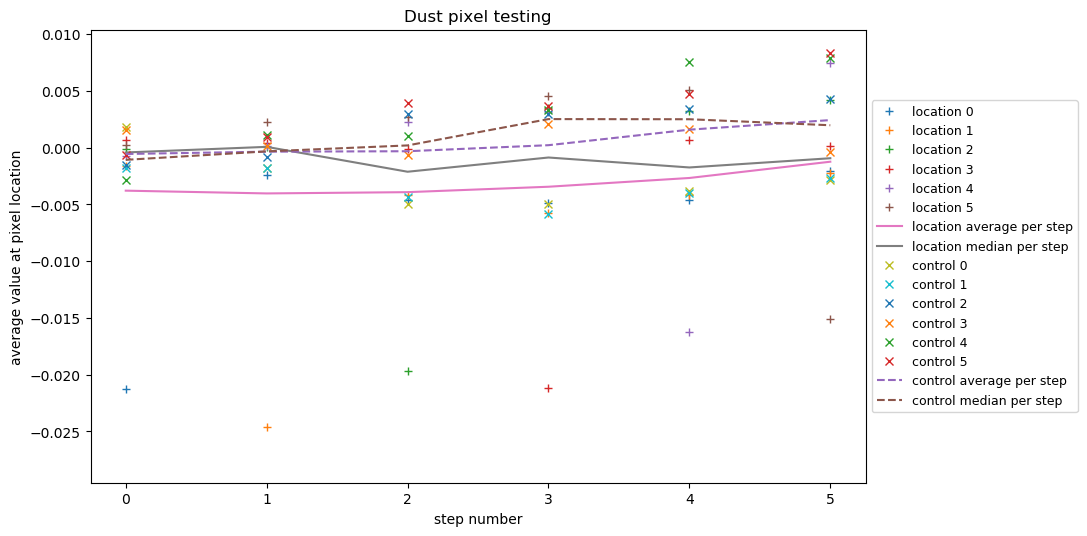

In [47]:
ddust = np.zeros((tot_step, tot_step))
ctrl = np.zeros((tot_step, tot_step))

ctrl_avg = np.zeros(tot_step)
ddust_avg = np.zeros(tot_step)
ctrl_med = np.zeros(tot_step)
ddust_med = np.zeros(tot_step)

for n in range(0, len(dust_center)):
    for m in range(0, tot_step):
        ddust[m][n] = data_set[m][dust_center[n][1]][dust_center[n][0]].value
        ctrl[m][n] = data_set[m][dust_center[n][1]+10][dust_center[n][0]].value
    ctrl_bin = ctrl[:,n]
    ddust_bin = ddust[:,n]
    ctrl_avg[n] = np.mean(ctrl_bin)
    ddust_avg[n] = np.mean(ddust_bin)
    ctrl_med[n] = np.median(ctrl_bin)
    ddust_med[n] = np.median(ddust_bin)

# plot the data
n_step = np.linspace(0, tot_step,tot_step, endpoint=False)
plt.figure(figsize=[10,6], dpi=100)
for n in range(0, tot_step):
    plt.plot(n_step, ddust[n], '+', label='location {0}'.format(n))
plt.plot(n_step, ddust_avg, label='location average per step')
plt.plot(n_step, ddust_med, label='location median per step')
for n in range(0, tot_step):
    plt.plot(n_step, ctrl[n], 'x', label='control {0}'.format(n))
plt.plot(n_step, ctrl_avg, '--', label='control average per step')
plt.plot(n_step, ctrl_med, '--', label='control median per step')
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([np.amin([np.amin(ddust), np.amin(ddust)])*1.2, 
          np.amax([np.amax(ddust), np.amax(ctrl)])*1.25])
plt.xlabel('step number')
plt.ylabel('average value at pixel location')
plt.title('Dust pixel testing')

In [53]:
avg_surf_flat = np.zeros(np.product(np.shape(mask)))
med_surf_flat = np.zeros(np.product(np.shape(mask)))
for n in range(0, np.product(np.shape(mask))):
    x = flat_data[:,n]
    # set parameters
    rmax = np.mean(x) + (1*np.std(x))
    rmin = np.mean(x) - (1*np.std(x))
    out_ind = []
    for m in range(0, tot_step): # filter
        if x[m] < rmin or x[m] > rmax: # if outlier
            #x[m] = np.nan
            out_ind.append(m)
    if len(out_ind) != 0: # if outlier exists
        x = np.delete(x, out_ind)
    # take average and median of data
    avg_surf_flat[n] = np.mean(x)
    med_surf_flat[n] = np.median(x)
# reshape the matricies back
medfm_pix_med = np.reshape(med_surf_flat, np.shape(mask))*data_set.unit
medfm_pix_avg = np.reshape(avg_surf_flat, np.shape(mask))*data_set.unit

# write the files
#file_nobias_pix = fits_folder+'flat_2in_ca{0}_n{1}_median_pixbias'.format(ca_resize, fm_num)
#dfx.write_fits(surface=pix_med, mask=mask, surf_parms=sp, filename=file_nobias_pix)

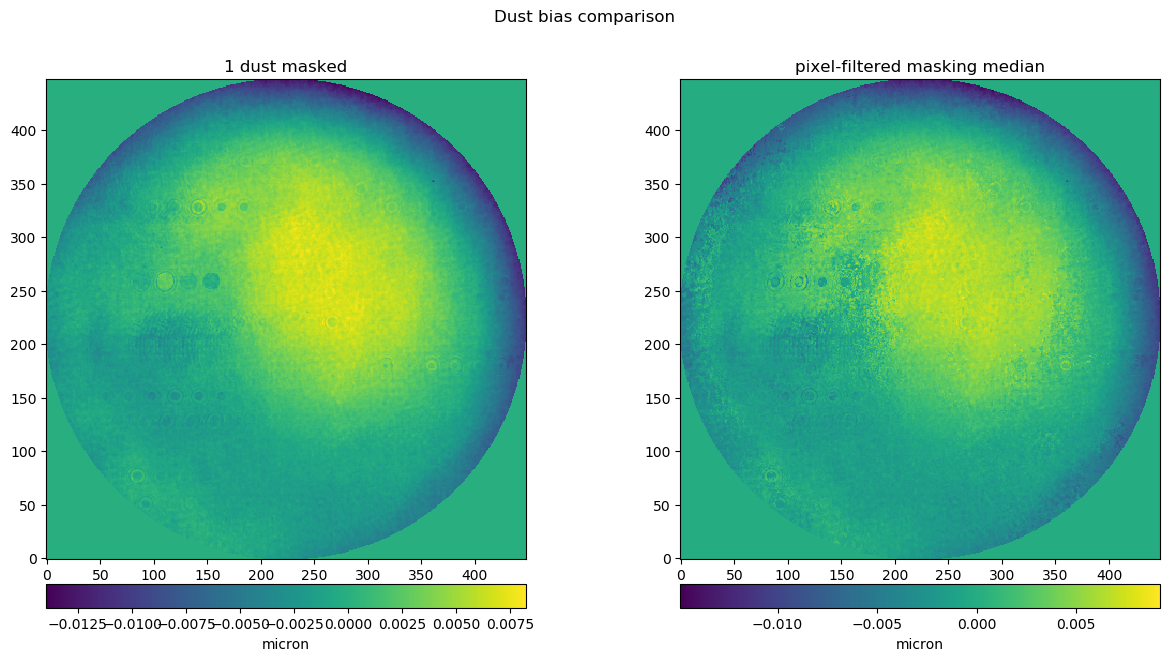

In [54]:
dfx.show2plots(supertitle='Dust bias comparison',
               data1 = medfm_mask1,
               plot1_label='1 dust masked',
               data2 = medfm_pix_med,
               plot2_label='pixel-filtered masking median',
               set_figsize=[15,7],
               set_dpi=100)

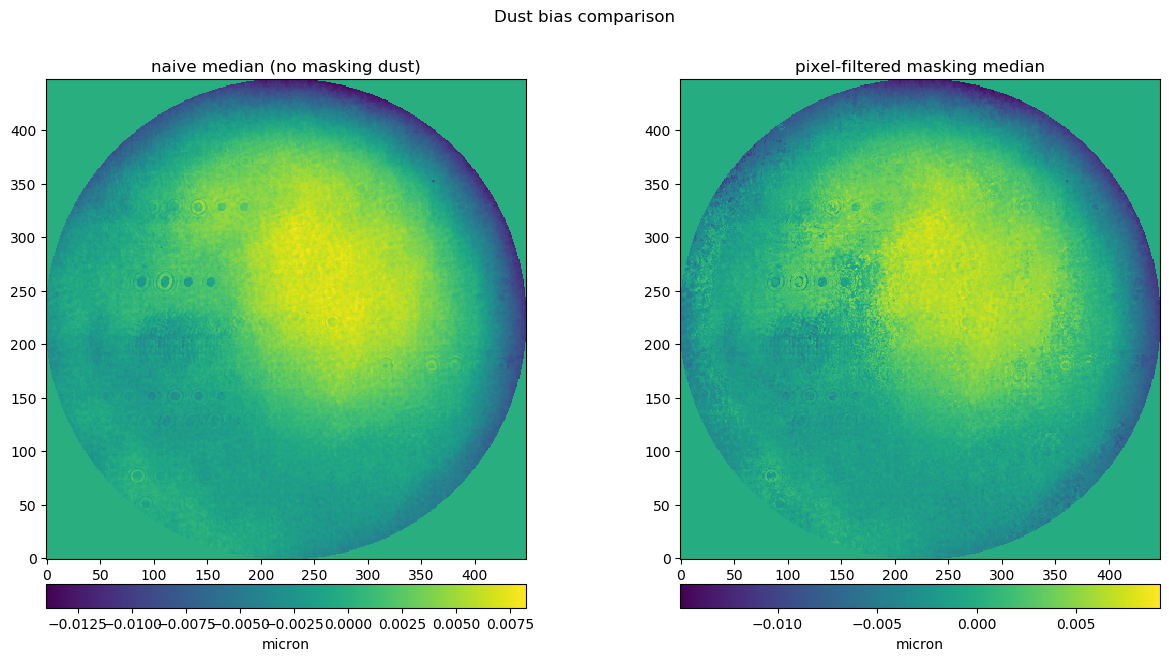

In [55]:
dfx.show2plots(supertitle='Dust bias comparison',
               data1 = medfm_bias,
               plot1_label='naive median (no masking dust)',
               data2 = medfm_pix_med,
               plot2_label='pixel-filtered masking median',
               set_figsize=[15,7],
               set_dpi=100)

In [56]:
# Pixel Filtering PSD
n_step = 'pix_filter'
fm_pixfilter = psd.surfPSD(surf_name = n_step)
fm_pixfilter.load_surf(data=medfm_pix_med, wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
fm_pixfilter.load_mask(mask=mask)
fm_pixfilter.calc_psd(oversamp = opt_parms['ovs'])
fm_pixfilter.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for {0} complete'.format(n_step))

PSD and radial profile for pix_filter complete


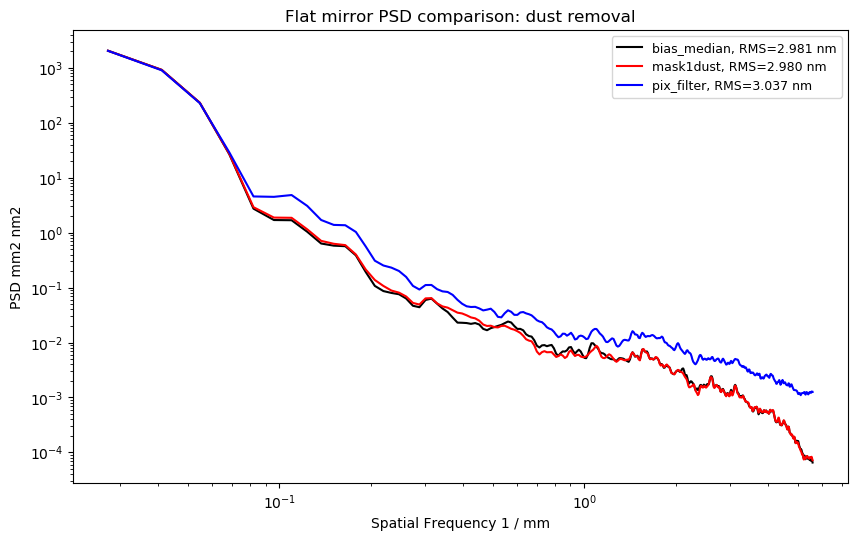

In [58]:
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(fm_bias.k_radial.value, fm_bias.psd_radial_cal.value, 'k',
           label='{0}, RMS={1:.3f}'.format(fm_bias.surf_name, fm_bias.rms))
plt.loglog(fm_mask1.k_radial.value, fm_mask1.psd_radial_cal.value, 'r', 
           label='{0}, RMS={1:.3f}'.format(fm_mask1.surf_name, fm_mask1.rms))
plt.loglog(fm_pixfilter.k_radial.value, fm_pixfilter.psd_radial_cal.value, 'b', 
           label='{0}, RMS={1:.3f}'.format(fm_pixfilter.surf_name, fm_pixfilter.rms))
plt.xlabel('Spatial Frequency {0}'.format(fm_bias.k_radial.unit))
plt.ylabel('PSD {0}'.format(fm_bias.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust removal')
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})